In [115]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#0000C0","#0000FF","#FFFFFF",
                                                                         "#FF0000","#C00000"])
import scha

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

### crear puntos

In [5]:
import fibonacci_sphere

In [6]:
def angulardist(theta1, phi1, theta2, phi2):
    return numpy.arccos(sin(theta1)*sin(theta2)*cos(phi1 - phi2)+cos(theta1)*cos(theta2))

In [7]:
theta_c, phi_c, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0))
lat_c, lon_c = 90 - numpy.rad2deg(theta_c), numpy.rad2deg(phi_c)

In [8]:
thetav, phiv = fibonacci_sphere.grid(4000)
inside_cap_index = angulardist(thetav, phiv, theta_c, phi_c) < theta_0
thetav = thetav[inside_cap_index]
phiv = phiv[inside_cap_index]

<IPython.core.display.Javascript object>


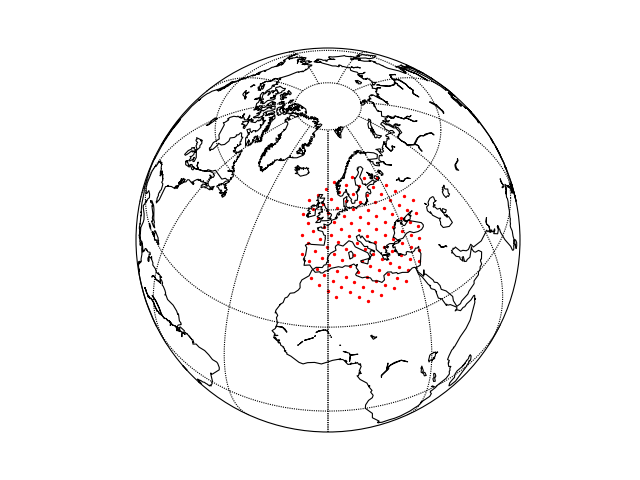

In [75]:
fig, ax = pyplot.subplots()

base = Basemap(projection="ortho", lat_0 = 45, lon_0 = 0, resolution="c")

base.drawmeridians(numpy.linspace(0, 360, 12), ax=ax)
base.drawparallels(numpy.linspace(-90, 90, 6), ax=ax)
base.drawcoastlines(ax=ax)

lat = 90 - numpy.rad2deg(thetav); lon = numpy.rad2deg(phiv)
base.scatter(lon, lat, s=4, latlon=True, ax=ax, color="red")

pyplot.show(fig)

### qué hora es

In [9]:
import datetime

In [10]:
date = datetime.datetime(2001, 1, 1)
ref = datetime.datetime(2000, 1, 1)
mjd = (date - ref).total_seconds()/(24*3600)

In [11]:
mjd

366.0

### vamos a enviar los datos por ahí

In [12]:
lat = 90 - numpy.rad2deg(thetav)
lon = numpy.rad2deg(phiv)
r = numpy.zeros_like(lat)
times = numpy.ones_like(lat)*mjd

datos = numpy.stack((lat, lon, r, times))

In [72]:
numpy.savetxt("/home/josecper/Programs/data/scha/pruebas/input.dat", datos.T, fmt="%8.4f", delimiter="\t")

#### vuelvo del planeta matlab con campos magnéticos

In [13]:
chaos_preds = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/CHAOS_preds.dat",
                            comments="%")

Bz_chaos, Bx_chaos, By_chaos = -chaos_preds[:, 4], -chaos_preds[:, 5], chaos_preds[:, 6]

### vamos a rotar

In [14]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

Bx_r = numpy.empty_like(Bx_chaos); By_r = numpy.empty_like(By_chaos); Bz_r = numpy.empty_like(Bz_chaos)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_chaos,By_chaos,Bz_chaos,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

#### hemos rotado

<IPython.core.display.Javascript object>


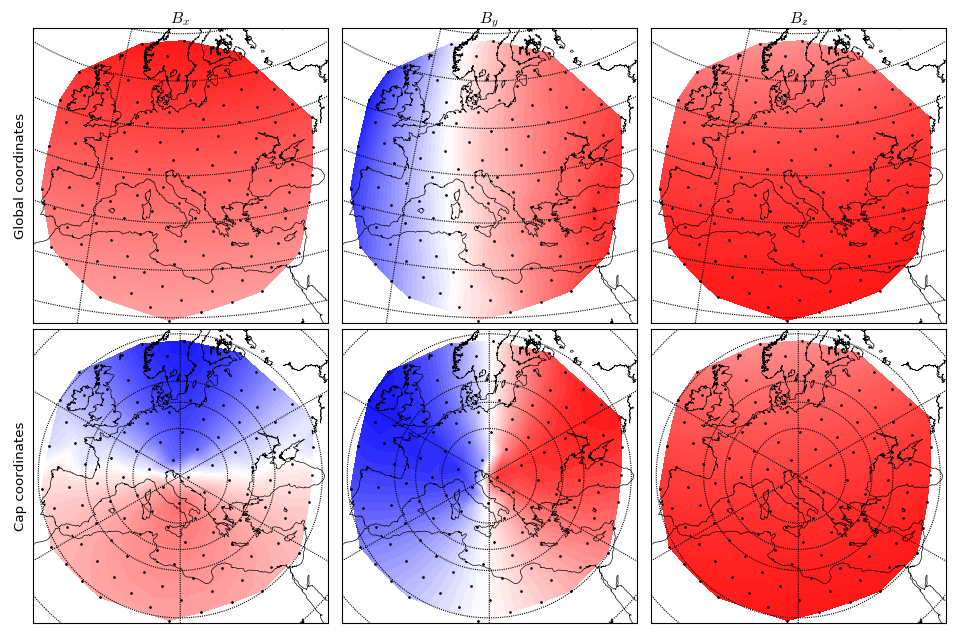

In [62]:
fig, axes = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)
scha.polar_tricontour(Bx_chaos, theta_r, phi_r, theta_0, ax=axes[0][0], base=base)
scha.polar_tricontour(By_chaos, theta_r, phi_r, theta_0, ax=axes[0][1], base=base)
scha.polar_tricontour(Bz_chaos, theta_r, phi_r, theta_0, ax=axes[0][2], base=base)

axes[0][0].set_title("$B_{x}$")
axes[0][1].set_title("$B_{y}$")
axes[0][2].set_title("$B_{z}$")

scha.polar_tricontour(Bx_r, theta_r, phi_r, theta_0, ax=axes[1][0], base=base)
scha.polar_tricontour(By_r, theta_r, phi_r, theta_0, ax=axes[1][1], base=base)
scha.polar_tricontour(Bz_r, theta_r, phi_r, theta_0, ax=axes[1][2], base=base)

axes[0][0].set_ylabel("Global coordinates")
axes[1][0].set_ylabel("Cap coordinates")

for ax in axes[0]:
    base2.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base2.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
for ax in axes[1]:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

fig.tight_layout()
pyplot.show(fig)

### vamos a invertir

#### primero hacemos la matriz de condición Axyz

In [16]:
ms = numpy.arange(0, 13);
roots = scha.degree(ms, theta0 = theta_0, max_k = 12)
k, m, n = scha.join_roots(roots)

In [17]:
Ax, Ay, Az = scha.condition_matrix_xyz(thetav, phiv, (k, m, n))

#### invertir la cosa

In [90]:
g = scha.invert_xyz(theta_r, phi_r, Bx_r, By_r, Bz_r, (k, m, n))

In [91]:
Bx_inv, By_inv, Bz_inv = scha.xyzfield(k, m, n, g, theta_r, phi_r)

<IPython.core.display.Javascript object>


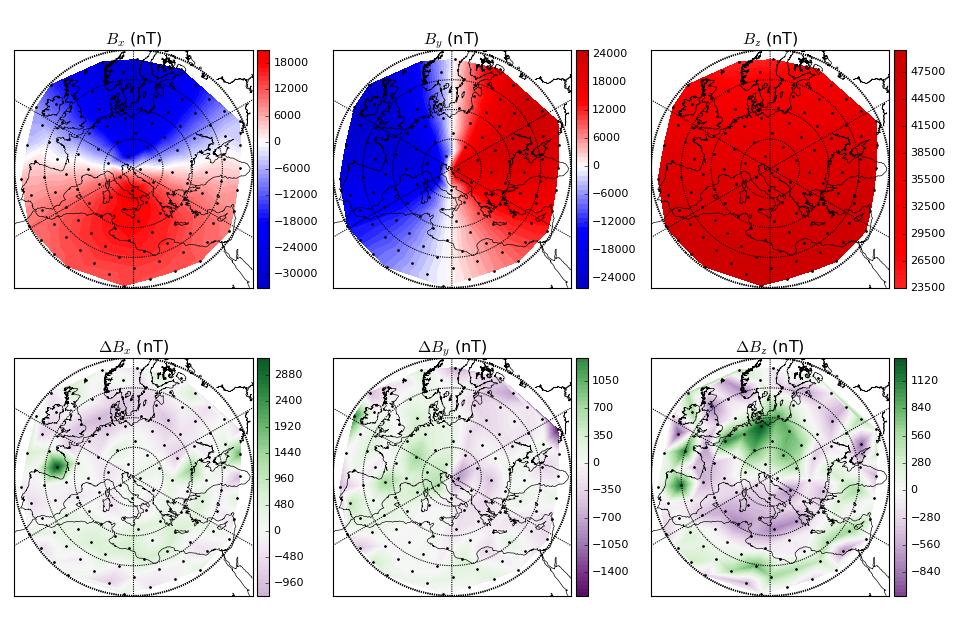

In [92]:
fig, (axes, raxes) = pyplot.subplots(2, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

for Bi, ax in zip((Bx_inv, By_inv, Bz_inv), axes):
    cbar=base.colorbar(scha.polar_tricontour(Bi, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr),
                       location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("$B_{x}$ (nT)"); axes[1].set_title("$B_{y}$ (nT)"); axes[2].set_title("$B_{z}$ (nT)")

for Bi, Bri, ax in zip((Bx_inv, By_inv, Bz_inv), (Bx_r, By_r, Bz_r), raxes):
    cbar=base.colorbar(scha.polar_tricontour(Bi-Bri, theta_r, phi_r, theta_0, ax=ax, base=base, cmap="PRGn"),
                  location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in raxes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
raxes[0].set_title(r"$\Delta B_{x}$ (nT)")
raxes[1].set_title(r"$\Delta B_{y}$ (nT)")
raxes[2].set_title(r"$\Delta B_{z}$ (nT)")
    
fig.tight_layout()

In [56]:
aa

{90: ([<matplotlib.lines.Line2D at 0x7f6eb1bbbb70>], [])}

In [29]:
print("{:>10}{:>10}        {:>12}        {:>11}        {:>11}".format("k", "m", "n(k,m)", "g(k,m)", "K(n,m)"))
print("----------------------------------------------------------------------------------------")

for ki, mi, ni, gi, si in zip(k, m, n, g, scha.schmidt_real(m, n, grid=False)):
    print("{:>10}{:>10}        {:12.7f}        {:+11.6e}        {:+11.6e}".format(ki, mi, ni, gi, si))

         k         m              n(k,m)             g(k,m)             K(n,m)
----------------------------------------------------------------------------------------
         0         0           0.0000000        -6.498255e+04        +1.000000e+00
         1         0           6.3832347        +3.175804e+04        +1.000000e+00
         1         1           4.8432386        +6.637712e+04        -2.658400e-01
         1        -1           4.8432386        +2.487572e+03        -2.658400e-01
         2         0          10.4885037        -6.655297e+04        +1.000000e+00
         2         1          10.4885037        -1.887813e+05        -1.288328e-01
         2        -1          10.4885037        -9.615673e+03        -1.288328e-01
         2         2           8.3552507        -2.888698e+04        +1.832857e-02
         2        -2           8.3552507        +1.492353e+03        +1.832857e-02
         3         0          15.3112037        +1.151569e+05        +1.000000e+00
  

### ahora vamos a hacer el DIF

#### primero con los vectores ya transformados

In [64]:
import xyzfield

In [149]:
D_r, I_r, F_r, H_r = xyzfield.xyz2difh(Bx_r, By_r, Bz_r)

<IPython.core.display.Javascript object>


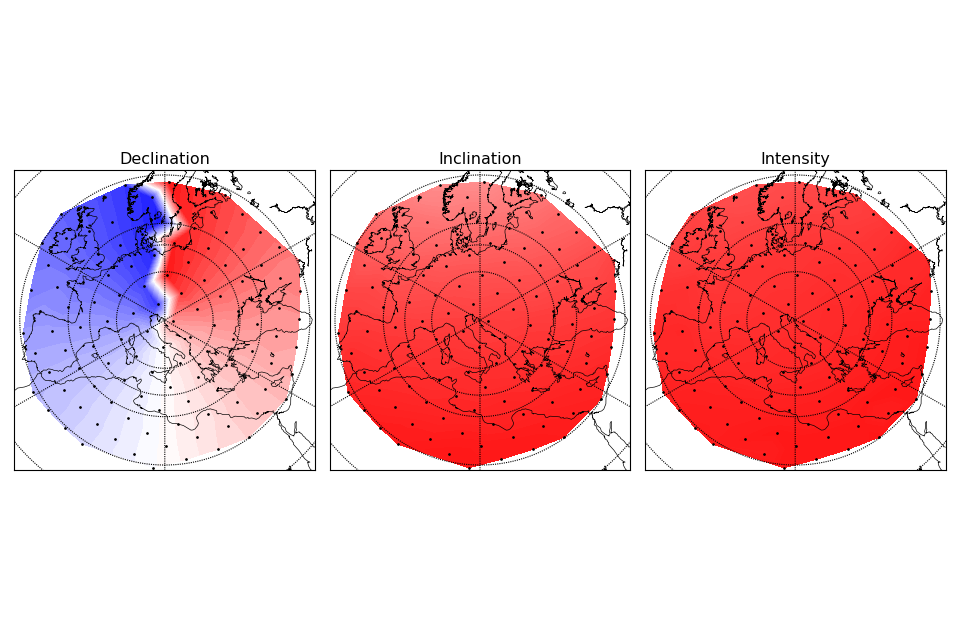

In [135]:
fig, axes = pyplot.subplots(1, 3, figsize=(12,8))

base = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="aeqd", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)
scha.polar_tricontour(D_r, theta_r, phi_r, theta_0, ax=axes[0], base=base)
scha.polar_tricontour(I_r, theta_r, phi_r, theta_0, ax=axes[1], base=base)
scha.polar_tricontour(F_r, theta_r, phi_r, theta_0, ax=axes[2], base=base)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(0, 90, 15), ax=ax, color="black")
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)

axes[0].set_title("Declination")
axes[1].set_title("Inclination")
axes[2].set_title("Intensity")

fig.tight_layout()
pyplot.show(fig)

#### enchufamos esto en la inversión ahí a lo loco yeah

In [183]:
importlib.reload(scha)
gp = scha.invert_dif(theta_r, phi_r, D_r, I_r, F_r, (k, m, n), g0=g, steps=12)

46784.1284652 -0.00475701577203
1090.59047275 -0.0543720173999
155590.944329 0.594601031753
210766.970342 -0.0583961222161
656333.145047 0.0158925928241
1365050.15003 -0.0388263849723
1286079.95138 -0.170323533304
785289.974705 0.244092781297
865625.217326 0.333513513229
1032600.37225 0.26877873949
1264434.09283 4.74834153693
2032595.54755 2.83749067661


/home/josecper/Programs/python/scha.py:307: UserWarning: inversion might not have converged (╯°□°)╯︵ ┻━┻
  if (sum(abs(delta)) > 1000): warnings.warn("inversion might not have converged (╯°□°)╯︵ ┻━┻")


In [171]:
g

array([ -6.49825487e+04,   3.17580302e+04,   6.63771181e+04,
         2.48757180e+03,  -6.65529637e+04,  -1.88781342e+05,
        -9.61567299e+03,  -2.88869792e+04,   1.49235326e+03,
         1.15156870e+05,   3.64848628e+05,   1.98542745e+04,
         8.22781273e+04,  -7.06699527e+03,   7.38109720e+03,
        -1.73498848e+03,  -1.58200755e+05,  -5.56037454e+05,
        -3.11770666e+04,  -1.53399680e+05,   1.68478114e+04,
        -1.91289337e+04,   6.22651336e+03,   7.82834550e+01,
        -2.14546032e+03,   1.78510357e+05,   6.71622933e+05,
         3.77081281e+04,   2.19105922e+05,  -2.90174413e+04,
         3.32169079e+04,  -1.29857145e+04,  -8.72894554e+02,
         5.70293148e+03,  -4.91603939e+02,  -2.61411252e+02,
        -1.67971643e+05,  -6.54521176e+05,  -3.60776981e+04,
        -2.44997905e+05,   3.67889960e+04,  -4.36622267e+04,
         1.98100434e+04,   1.94403008e+03,  -9.49828069e+03,
         1.09791726e+03,   4.58649460e+02,   7.34266283e+02,
        -1.41093784e+03,